# Comparing Trading Cost by A/B Test

### Imports

In [2]:
import numpy as np
import scipy
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt

## Running an ad hoc experiment

To understand A/B testing, we need to first understand the problems it solves. One way to do that is to, for a moment, ignore A/B testing methods and, instead, proceed simply and intuitively and see what problems we run into. Specifically, let's reconfigure a trading system and see if that reduces trading costs.

Imagine you're a quant, and you're developing an agency trading system. The system takes in customer orders like "Buy 1,000 shares of AAPL stock over the next hour," and after buying the shares on behalf of the customer, it reports the cost of executing the trade. Customers, of course, prefer lower costs, so you use execution cost as your business metric. Your job as a quant is to find ways to modify the trading system that result in lower execution cost.

A simple change you can make to the system is to buy the shares on a different exchange. An *exchange* is a third-party service that facilitates anonymous trading between any two trading systems. Your system sends trading commands to the exchange's server. A command might be "Buy 100 shares of AAPL right now." If, for example, it sends that command ten times over the course of an hour, it will have purchased 1,000 shares of AAPL stock for one of your customers.

At present, your system trades on an exchange run by a company called ASDAQ (version A of your system). You suspect it might be cheaper to trade on the exchange BYSE (version B of your system). You'll measure execution cost on each exchange and compare to see if your suspicion is correct.

### Simulate the trading system

In [3]:
def trading_system(exchange):
    if exchange == "ASDAQ":
        execution_cost = 12
    elif exchange == "BYSE":
        execution_cost = 10
    execution_cost += np.random.normal()
    return execution_cost

### Compare execution costs

In [4]:
np.random.seed(17)
print(trading_system("ASDAQ"))
print(trading_system("BYSE"))

12.27626589002132
8.145371921193496


In [5]:
np.random.seed(18)
print(trading_system("ASDAQ"))
print(trading_system("BYSE"))

12.079428443806204
12.190202357414222


### Variation

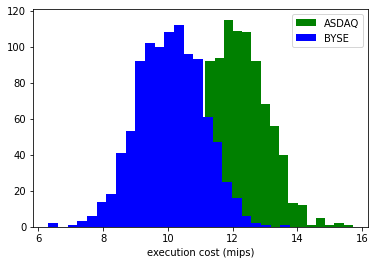

In [6]:
np.random.seed(17)
a = np.array([trading_system("ASDAQ") for _ in range(1000)])
b = np.array([trading_system("BYSE") for _ in range(1000)])
plt.hist(a, 25, color="green")
plt.hist(b, 25, color="blue")
plt.legend(["ASDAQ", "BYSE"])
plt.xlabel("execution cost (mips)")
plt.show()

This sort of variation from measurement to measurement is typical, and it makes your decision about which exchange to use unreliable. A/B testing uses a technique called *replication* - averaging over multiple measurements - to increase the reliability of your decision. To get a feel for how this works, let's take an average over 100 measurements:

In [7]:
np.random.seed(17)
print(np.array([trading_system("ASDAQ") for _ in range(100)]).mean())
print(np.array([trading_system("BYSE") for _ in range(100)]).mean())

12.111509794247766
10.008382946497413


### Bias

Since you need to take many measurements, you'll need to do a little planning to get them all done. You'll take all the BYSE measurements in the morning, go get lunch, then take the ASDAQ measurements in the afternoon. What you aren't aware of is the fact that all trading---regardless of exchange---is cheaper in the afternoon (for reasons that have to do with natural market dynamics). The following listing simulates this effect; let's call it the *time-of-day effect*.

In [8]:
#  A simulator that accounts for time of day
def trading_system_tod(exchange, time_of_day):
    if time_of_day == "morning":
        bias = 2.5
    elif time_of_day == "afternoon":
        bias = 0
    return bias + trading_system(exchange)

In [9]:
print(np.array([trading_system_tod("BYSE", "morning") for _ in range(1000)]).mean())
print(np.array([trading_system_tod("ASDAQ", "afternoon") for _ in range(1000)]).mean())

12.505928091007245
12.061048269372224


If we were unaware of the time-of-day effect, we would conclude from this measurement that ASDAQ’s trading costs were lower than BYSE’s. This is the opposite result of the previous section, and it is wrong. Also, it persists. If you rerun this measurement, you’ll usually get the result that ASDAQ is cheaper.

This incorrect result comes from applying the time-of-day bias differently—and consistently—to ASDAQ than to BYSE. When a bias is applied differently and consistently (to the two versions of the system being compared) like this, it’s called confounder bias. Confounder bias can lead to incorrect decisions about whether to make changes to your system.

A simple trick to remove confounder bias is randomization. You still run your experiment in both morning and afternoon, as you planned, but every time your system makes a trade, it should flip a coin. If the coin comes up heads, send the orders to ASDAQ. If it comes up tails, send them to BYSE. You’ll find that about half of your ASDAQ orders happen in the morning and half happen in the afternoon. The same will hold true for BYSE. The following listing shows how to do this explicitly.

In [10]:
# A randomized measurement
def randomized_measurement():
    asdaq_measurement = []
    byse_measurement = []
    for tod in ["morning", "afternoon"]:
        for _ in range(100):
            if np.random.randint(2) == 0:
                asdaq_measurement.append(trading_system_tod("ASDAQ", tod))
            else:
                byse_measurement.append(trading_system_tod("BYSE", tod))
    return (np.array(asdaq_measurement).mean(), 
            np.array(byse_measurement).mean())

In [11]:
np.random.seed(17)
randomized_measurement()

(13.39588870623852, 11.259639285763223)

These measurements show that ASDAQ is more expensive than BYSE, which is correct. If you run randomized_measurement() again, you’ll find that ASDAQ is more expensive. Randomization removed the time-of-day bias from your measurement.

The amazing thing is that you don’t have to know about the time-of-day effect to remove it from your measurements. Put another way, the randomization logic (i.e., flipping a coin) does not use any information about the biases in your system. Randomization removes all confounder biases without you having to know they even exist. But beware, they do exist, and if you don’t randomize, you’ll often end up making bad decisions about how to improve your trading system.

Variation and bias are the two problems that experiments aim to solve. Variation causes measurements to be sometimes too high and sometimes too low, although on average they’ll be correct. Bias causes measurements to be consistently too high or too low, no matter how many measurements you average over.

A/B testing uses replication to reduce variation and randomization to remove bias.

## Take a precise measurement

### Mitigate measurement variation with replication

In [12]:
# Aggregate measurement
def aggregate_measurement(exchange, num_individual_measurements):
    individual_measurements = np.array(
        [trading_system(exchange) for _ in range(num_individual_measurements)]
    )
    return individual_measurements.mean()

(7.941655880462077, 16.14289667197706, 0.0, 290.85)


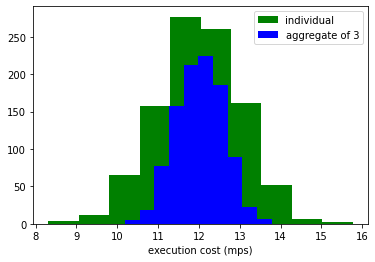

In [13]:
plt.hist(np.array([trading_system("ASDAQ") for _ in range(1000)]), color="green")
plt.hist(np.array([aggregate_measurement("ASDAQ", 3) for _ in range(1000)]), color="blue")
plt.xlabel("execution cost (mps)")
print(plt.axis())
plt.legend(["individual", "aggregate of 3"])
plt.show()

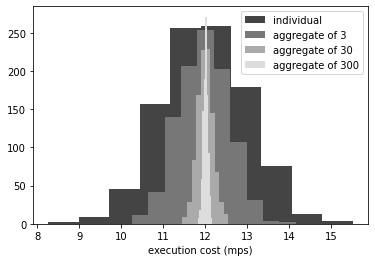

In [14]:
color_1 = "#444444"
color_2 = "#777777"
color_3 = "#AAAAAA"
color_4 = "#DDDDDD"

plt.hist(np.array([trading_system("ASDAQ") for _ in range(1000)]), color=color_1)
plt.hist(np.array([aggregate_measurement("ASDAQ", 3) for _ in range(1000)]), color=color_2)
plt.hist(np.array([aggregate_measurement("ASDAQ", 30) for _ in range(1000)]), color=color_3)
plt.hist(np.array([aggregate_measurement("ASDAQ", 300) for _ in range(1000)]), color=color_4)
plt.xlabel("execution cost (mps)")
plt.legend(["individual", "aggregate of 3", "aggregate of 30", "aggregate of 300"])
plt.show()

In [15]:
# Aggregate measurement with SE
def aggregate_measurement_with_se(exchange, num_individual_measurements):
    individual_measurements = np.array(
        [trading_system(exchange) for _ in range(num_individual_measurements)]
    )
    aggregate_measurement = individual_measurements.mean()
    sd_1 = individual_measurements.std()
    se = sd_1 / np.sqrt(num_individual_measurements)
    return aggregate_measurement, se

In [16]:
np.random.seed(17)
print(aggregate_measurement_with_se("ASDAQ", 300))
print(aggregate_measurement_with_se("BYSE", 300))

(12.000257642551059, 0.060254756364981225)
(10.051095649188758, 0.05714189794415452)
